
# 📈 Signals in Time and Frequency Domain

## 0. Types of Signals

- **Continuous-time**: defined at every instant (e.g. sound pressure, ECG voltage)  
- **Discrete-time**: defined at sampled instants (e.g. samples from an ADC)  
- **Deterministic**: predictable, described by equations (e.g. sine wave)  
- **Random / stochastic**: unpredictable, statistical (e.g. noise)  
- **Periodic**: repeats over time (e.g. mains 50 Hz)  
- **Aperiodic**: does not repeat (e.g. transient pulse)

**Key parameters:**
- **Amplitude** — height of the waveform  
- **Frequency** — cycles per second  
- **Phase** — horizontal shift  
- **Offset / DC** — mean value



## 1. Time Domain Example


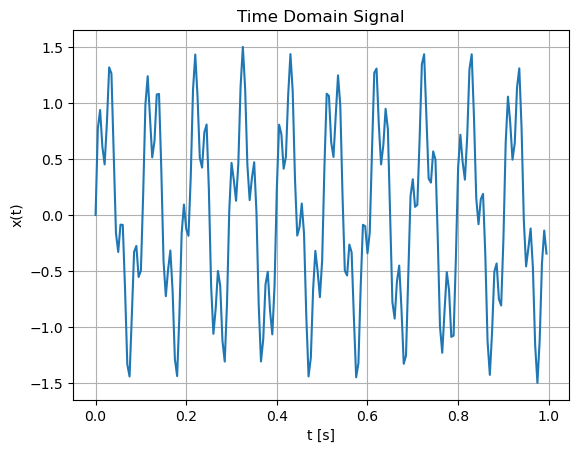

In [1]:
import numpy as np, matplotlib.pyplot as plt

fs = 200                                # Sampling rate: 200 Hz
t = np.arange(0,1,1/fs)                 # Time vector: 1 second, 200 samples

x = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*37.7*t)  # leakage only at 37.7 Hz (second sine), 10 Hz is bin-aligned
# x = np.sin(2*np.pi*10.7*t) + 0.5*np.sin(2*np.pi*40*t)  # leakage only at 10.7 Hz (first sine), 40 Hz is bin-aligned
# x = np.sin(2*np.pi*10.7*t) + 0.5*np.sin(2*np.pi*37.7*t)  # leakage at both 10.7 Hz and 37.7 Hz (both non-bin-aligned)

plt.plot(t,x)
plt.title('Time Domain Signal')
plt.xlabel('t [s]'); plt.ylabel('x(t)')
plt.grid(); plt.show()


## 2. Frequency and Phase as Complex Numbers

Fourier series / transform represent signals as sums of complex exponentials:

$$ e^{j\omega t} = \cos(\omega t) + j\sin(\omega t) $$

- **Magnitude** = amplitude  
- **Angle** = phase  


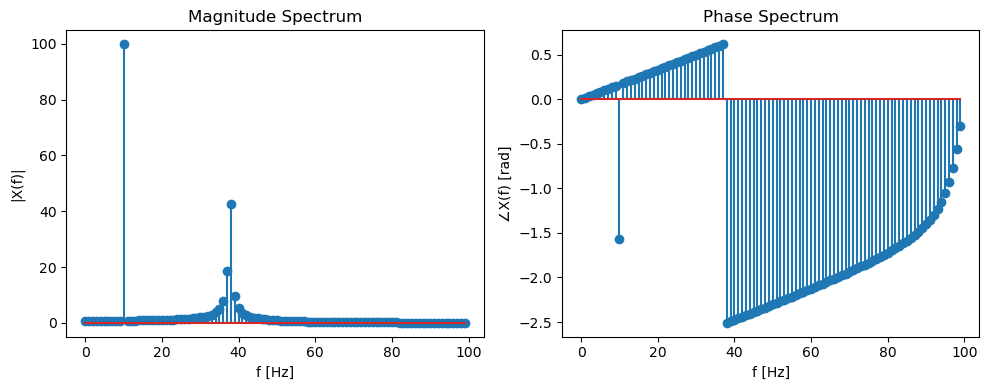

In [2]:
X = np.fft.fft(x)
f = np.fft.fftfreq(len(x),1/fs)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.stem(f[:len(f)//2], np.abs(X[:len(f)//2]))
plt.title('Magnitude Spectrum')
plt.xlabel('f [Hz]'); plt.ylabel('|X(f)|')

plt.subplot(1,2,2)
plt.stem(f[:len(f)//2], np.angle(X[:len(f)//2]))
plt.title('Phase Spectrum')
plt.xlabel('f [Hz]'); plt.ylabel('∠X(f) [rad]')
plt.tight_layout(); plt.show()

## Understanding the FFT Plots

### Phase Spectrum
- The phase spectrum shows the **starting angle** of each frequency component.
- If a frequency bin has **almost zero magnitude**, its phase is **undefined and random**.
- This creates noisy-looking phase plots when plotted for all bins.
- ✅ To avoid this, we **ignore bins whose magnitude is below a threshold** (e.g. `1e-2`).

> Example: A `sin()` wave has phase ≈ −90° (−π/2 rad) because it is just a `cos()` shifted by −90°.
> If no time shift is present, we expect clear phase points only at the signal's frequencies.

### Magnitude Scale (Linear vs dB)
- FFT magnitudes can vary by **several orders of magnitude**.
- On a **linear scale**, small components are hard to see next to large peaks.
- A **logarithmic scale in decibels (dB)** compresses this range and makes small signals visible:

$$
\text{dB} = 20 \cdot \log_{10}\left(\frac{|X(f)|}{\max|X(f)|}\right)
$$

- 0 dB corresponds to the largest component  
- −20 dB ≈ 10× smaller, −40 dB ≈ 100× smaller

### Example Plots
Below: Same FFT data shown on linear scale and dB scale, and phase shown only for bins with magnitude > threshold.


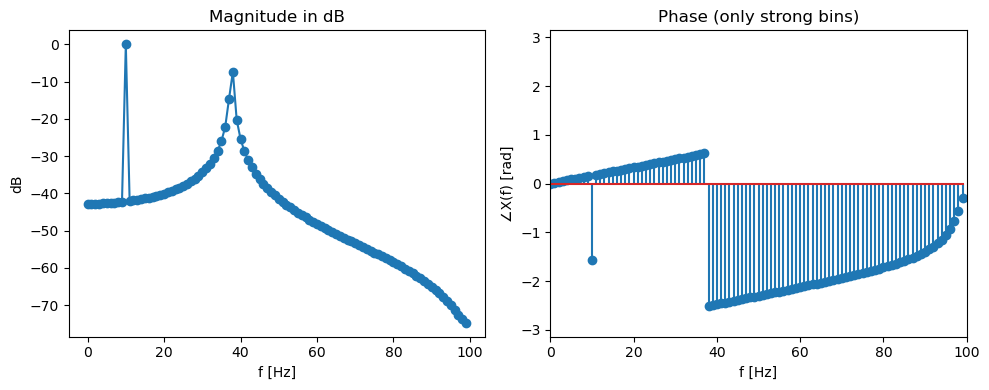

In [3]:
X = np.fft.fft(x)
f = np.fft.fftfreq(len(x), 1/fs)
mag = np.abs(X)
phase = np.angle(X)

mask = mag > 1e-2
mag_db = 20*np.log10(mag/np.max(mag)+1e-12)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(f[:len(f)//2], mag_db[:len(f)//2], '-o')
plt.title('Magnitude in dB')
plt.xlabel('f [Hz]'); plt.ylabel('dB')

plt.subplot(1,2,2)
plt.stem(f[:len(f)//2][mask[:len(f)//2]], phase[:len(f)//2][mask[:len(f)//2]])
plt.title('Phase (only strong bins)')
plt.xlabel('f [Hz]'); plt.ylabel('∠X(f) [rad]')
plt.ylim(-np.pi, np.pi)
plt.xlim(0, 100)

plt.tight_layout(); plt.show()

## Try It Yourself — When Period ≠ Window

In the example above, the sine waves fit an **integer number of cycles** into the window.
This makes the FFT spectrum show **clean, sharp peaks**.

In real signals this almost never happens!

**Tinker with the code**:

- Change the frequencies slightly (for example 10 → 10.7 Hz and 37.7 → 40 Hz)
- Keep the same sampling rate and number of samples

```python
x = np.sin(2*np.pi*10.7*t) + 0.5*np.sin(2*np.pi*40*t)
```

**Observe what happens**:
- The peaks become wider
- Energy spreads into nearby frequency bins
- This is called **spectral leakage**


## 3. Windowing Effects

- In practice we analyze **finite segments** (windows) of signals  
- Abrupt cut → spectral leakage  
- Windowing (Hann, Hamming, etc.) reduces leakage by smoothing edges  
- Tradeoff: better leakage suppression vs wider main lobe
- **Rectangular window** means no smoothing, just the abrupt edges. The window functions in frequency domain are shown below.


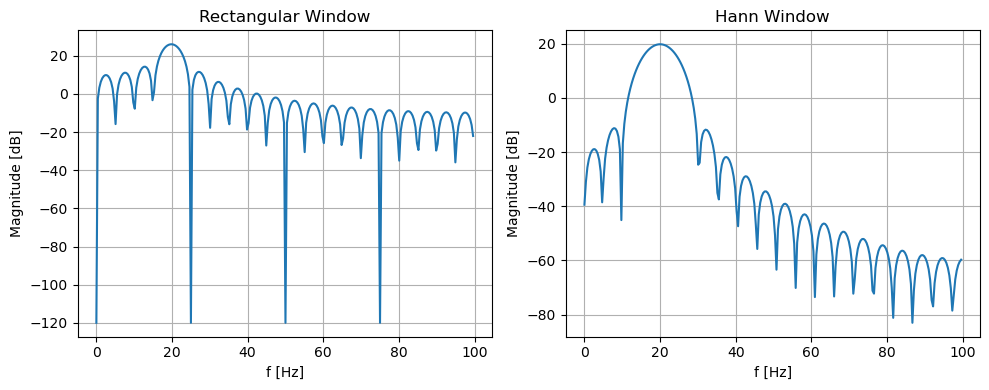

In [4]:
from scipy.signal import windows

x_full = np.sin(2*np.pi*20*t)
x_cut = x_full[:40]  # abrupt cut
x_win = x_cut * windows.hann(40)

def plot_fft(sig, title):
    X = np.fft.fft(sig, 512)
    f = np.fft.fftfreq(512,1/fs)
    plt.plot(f[:256], 20*np.log10(np.abs(X[:256])+1e-6))
    plt.title(title); plt.xlabel('f [Hz]'); plt.ylabel('Magnitude [dB]'); plt.grid()

plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plot_fft(x_cut,'Rectangular Window')
plt.subplot(1,2,2); plot_fft(x_win,'Hann Window')
plt.tight_layout(); plt.show()

## 4. Exercise — Leakage Reduction with Hann Window

In this exercise you will:

- Generate a signal with two sine components:  
  - 10 Hz (bin aligned)  
  - 37.7 Hz (not bin aligned → causes leakage)
- Apply a **Hann window** to the signal before FFT
- Compare the **magnitude and phase spectra** to the unwindowed version

**Tasks:**
1. Plot the time-domain signal
2. Compute and plot FFT without window
3. Compute and plot FFT with Hann window
4. Explain how the Hann window changes:
   - Peak width  
   - Leakage level  
   - Phase shape

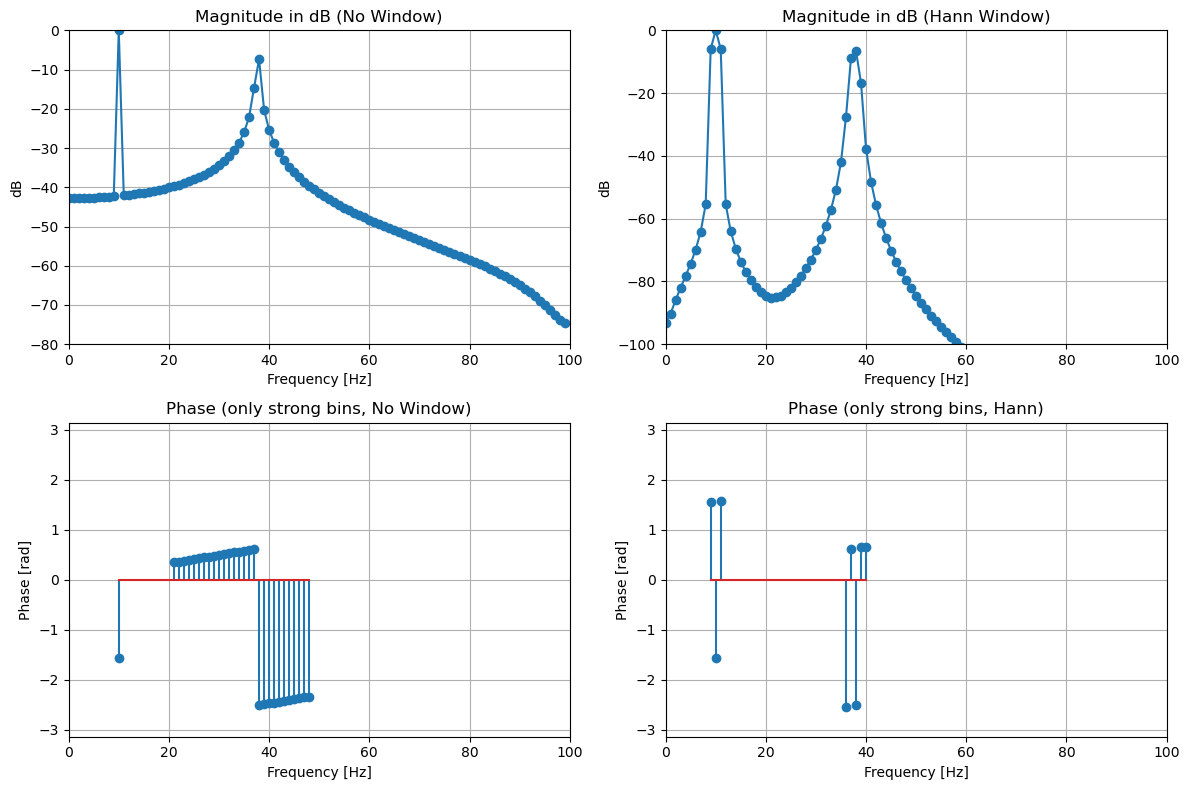

In [5]:
# ----------------------------
# Generate test signal (1 s)
# ----------------------------
fs = 200
t = np.arange(0, 1, 1/fs)
# 10 Hz is bin-aligned; 37.7 Hz is not (causes leakage)
x = np.sin(2*np.pi*10*t) + 0.5*np.sin(2*np.pi*37.7*t)

# ----------------------------
# FFT: No window (rectangular)
# ----------------------------
X = np.fft.fft(x)
f = np.fft.fftfreq(len(x), 1/fs)
mag = np.abs(X)
phase = np.angle(X)
mag_db = 20*np.log10(mag/np.max(mag) + 1e-12)  # dB relative to peak
mask = mag_db > -40  # show phase only for bins above -40 dB

# ----------------------------
# FFT: Hann window
# ----------------------------
x_hann = x * np.hanning(len(x))        # apply Hann
X_hann = np.fft.fft(x_hann)
f_h = np.fft.fftfreq(len(x_hann), 1/fs)
mag_h = np.abs(X_hann)
phase_h = np.angle(X_hann)
mag_db_h = 20*np.log10(mag_h/np.max(mag_h) + 1e-12)
mask_h = mag_db_h > -40

# ----------------------------
# Plot: Magnitude (top row) and Phase (bottom row)
# Left = No window, Right = Hann
# ----------------------------
plt.figure(figsize=(12,8))

# --- Magnitude, No window ---
plt.subplot(2,2,1)
plt.plot(f[:len(f)//2], mag_db[:len(f)//2], '-o')
plt.title('Magnitude in dB (No Window)')
plt.xlabel('Frequency [Hz]'); plt.ylabel('dB'); plt.grid(True)
plt.xlim(0, 100); plt.ylim(-80, 0)

# --- Magnitude, Hann ---
plt.subplot(2,2,2)
plt.plot(f_h[:len(f_h)//2], mag_db_h[:len(f_h)//2], '-o')
plt.title('Magnitude in dB (Hann Window)')
plt.xlabel('Frequency [Hz]'); plt.ylabel('dB'); plt.grid(True)
plt.xlim(0, 100); plt.ylim(-100, 0)

# --- Phase, No window (only strong bins) ---
plt.subplot(2,2,3)
plt.stem(f[:len(f)//2][mask[:len(f)//2]], phase[:len(f)//2][mask[:len(f)//2]])
plt.title('Phase (only strong bins, No Window)')
plt.xlabel('Frequency [Hz]'); plt.ylabel('Phase [rad]')
plt.grid(True); plt.xlim(0, 100); plt.ylim(-np.pi, np.pi)

# --- Phase, Hann (only strong bins) ---
plt.subplot(2,2,4)
plt.stem(f_h[:len(f_h)//2][mask_h[:len(f_h)//2]], phase_h[:len(f_h)//2][mask_h[:len(f_h)//2]])
plt.title('Phase (only strong bins, Hann)')
plt.xlabel('Frequency [Hz]'); plt.ylabel('Phase [rad]')
plt.grid(True); plt.xlim(0, 100); plt.ylim(-np.pi, np.pi)

plt.tight_layout()
plt.show()

- Without a window, the peaks are sharp but there is a lot of leakage and the phase looks messy.

- With the Hann window, the peaks are wider, but leakage is much smaller and the phase is clear only at the real frequencies.

- So the Hann window makes the spectrum cleaner, but the peaks are not as sharp.


## 5. Oversampling Effects

- Higher sampling rate → more points per cycle  
- Improves **frequency resolution** and **phase accuracy** in FFT  
- Does **not** change actual signal frequencies  
- Also pushes aliasing further away (more headroom for filters)


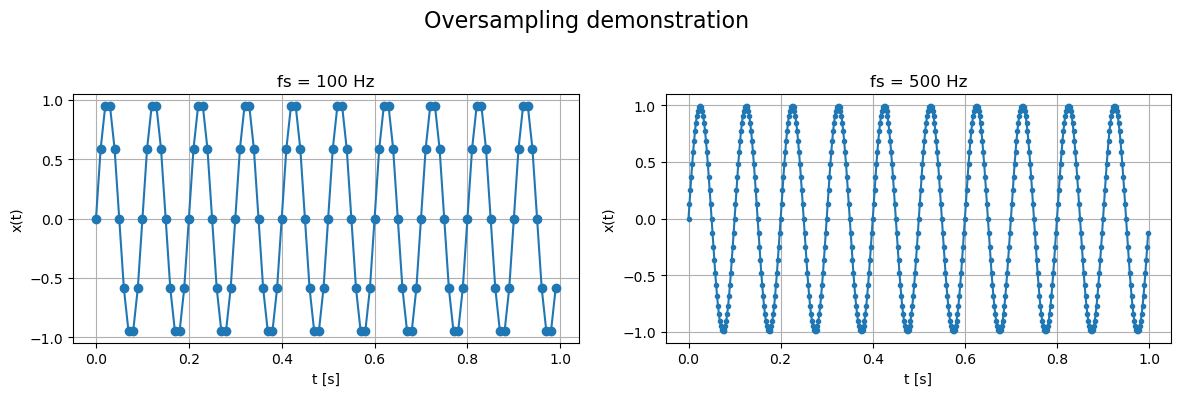

In [6]:
fs1, fs2 = 100, 500
t1 = np.arange(0,1,1/fs1)
t2 = np.arange(0,1,1/fs2)
x1 = np.sin(2*np.pi*10*t1)
x2 = np.sin(2*np.pi*10*t2)

plt.figure(figsize=(12,4))
plt.suptitle('Oversampling demonstration', fontsize=16)

plt.subplot(1,2,1)
plt.plot(t1, x1, 'o-')
plt.title('fs = 100 Hz')
plt.xlabel('t [s]')
plt.ylabel('x(t)')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(t2, x2, '.-')
plt.title('fs = 500 Hz')
plt.xlabel('t [s]')
plt.ylabel('x(t)')
plt.grid(True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

## 6. Exercise

Plot the amplitude spectra of sampled and oversampled data above.

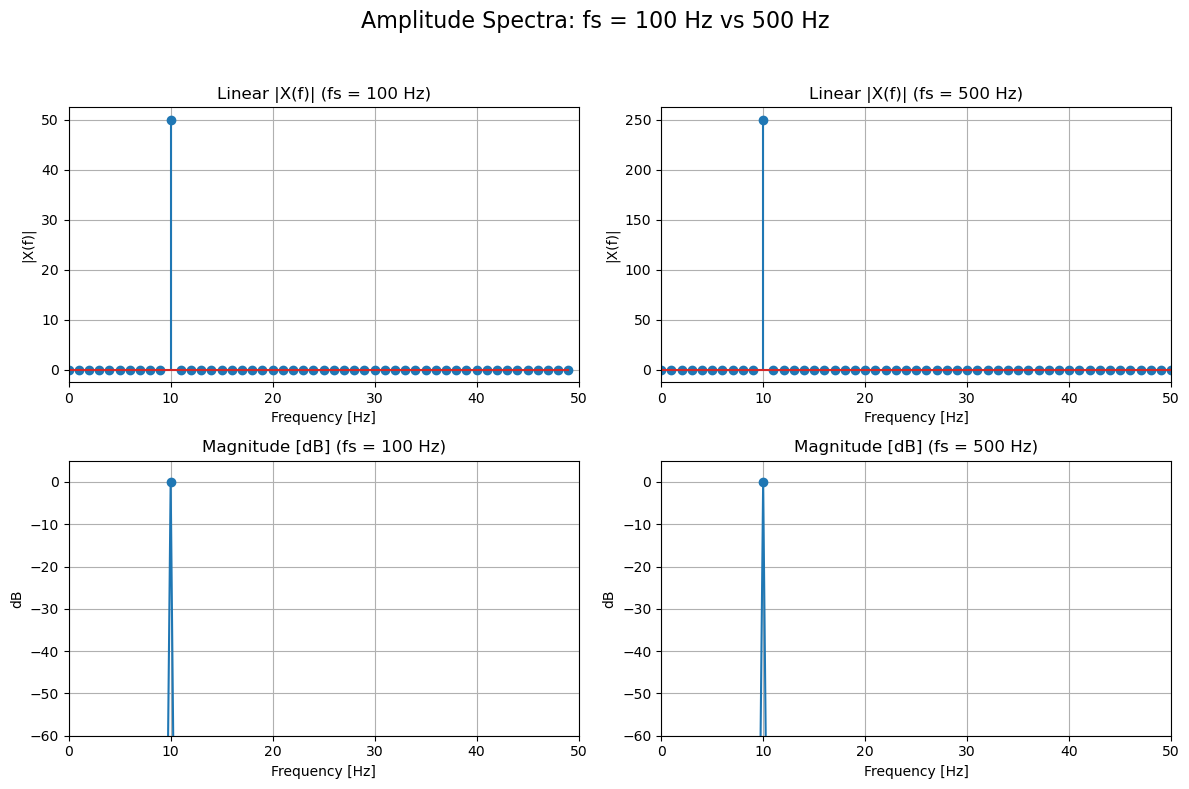

In [7]:
# Amplitude spectra for sampled (fs=100) vs oversampled (fs=500)

# FFTs
X1 = np.fft.fft(x1)
f1 = np.fft.fftfreq(len(x1), 1/fs1)

X2 = np.fft.fft(x2)
f2 = np.fft.fftfreq(len(x2), 1/fs2)

# Normalized magnitude in dB
mag1_db = 20*np.log10(np.abs(X1)/np.max(np.abs(X1)) + 1e-12)
mag2_db = 20*np.log10(np.abs(X2)/np.max(np.abs(X2)) + 1e-12)

plt.figure(figsize=(12,8))
plt.suptitle('Amplitude Spectra: fs = 100 Hz vs 500 Hz', fontsize=16)

# --- Top row: linear magnitude (teacher style) ---
plt.subplot(2,2,1)
plt.stem(f1[:len(f1)//2], np.abs(X1[:len(X1)//2]))
plt.title('Linear |X(f)| (fs = 100 Hz)')
plt.xlabel('Frequency [Hz]'); plt.ylabel('|X(f)|'); plt.grid(True)
plt.xlim(0, 50)

plt.subplot(2,2,2)
plt.stem(f2[:len(f2)//2], np.abs(X2[:len(X2)//2]))
plt.title('Linear |X(f)| (fs = 500 Hz)')
plt.xlabel('Frequency [Hz]'); plt.ylabel('|X(f)|'); plt.grid(True)
plt.xlim(0, 50)

# --- Bottom row: same but in dB ---
plt.subplot(2,2,3)
plt.plot(f1[:len(f1)//2], mag1_db[:len(mag1_db)//2], 'o-')
plt.title('Magnitude [dB] (fs = 100 Hz)')
plt.xlabel('Frequency [Hz]'); plt.ylabel('dB'); plt.grid(True)
plt.xlim(0, 50); plt.ylim(-60, 5)

plt.subplot(2,2,4)
plt.plot(f2[:len(f2)//2], mag2_db[:len(mag2_db)//2], 'o-')
plt.title('Magnitude [dB] (fs = 500 Hz)')
plt.xlabel('Frequency [Hz]'); plt.ylabel('dB'); plt.grid(True)
plt.xlim(0, 50); plt.ylim(-60, 5)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 7. Exercise — Time vs Frequency View of a Real Signal

You are given a short ECG (electrocardiogram) segment sampled at 360 Hz.  
Tasks:
1. Plot the ECG in the **time domain**.
2. Compute and plot the **magnitude and phase spectrum**.
3. Estimate:
   - The dominant heart rate (in beats per minute)
   - The main noise frequencies present

Discuss: Which parts of the ECG appear as low-frequency vs high-frequency components?


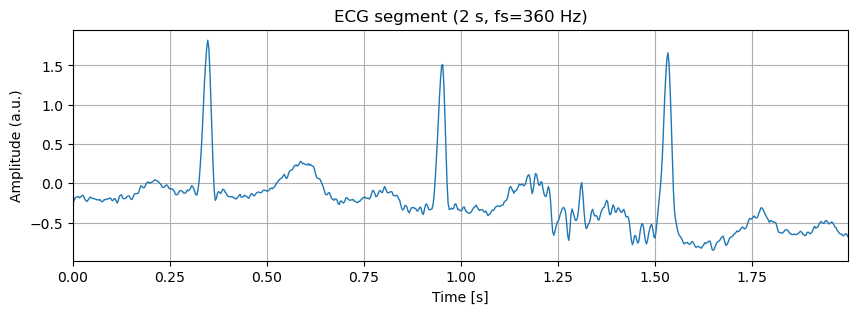

In [8]:
from scipy import datasets
import numpy as np, matplotlib.pyplot as plt

# Load the built-in ECG sample
ecg = datasets.electrocardiogram()
fs = 360  # Hz, sampling rate

# Use only 2 seconds
ecg = ecg[:2*fs]
t = np.arange(len(ecg)) / fs

# Plot time-domain ECG
plt.figure(figsize=(10,3))
plt.plot(t, ecg, lw=1)
plt.title('ECG segment (2 s, fs=360 Hz)')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude (a.u.)')
plt.grid(True)
plt.xlim(t[0], t[-1])
plt.show()

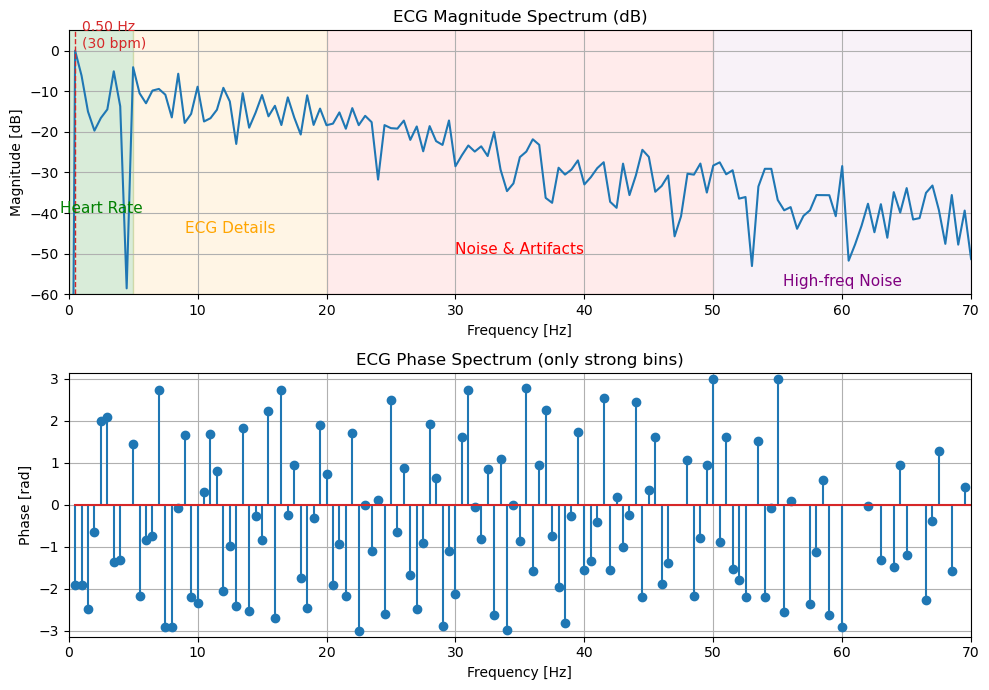

Dominant heart-rate peak: 0.50 Hz → 30 bpm


In [9]:
# --- ECG magnitude & phase + HR estimation in one block ---

# FFT
x0 = ecg - np.mean(ecg)                 # remove DC
X = np.fft.fft(x0)
f = np.fft.fftfreq(len(x0), 1/fs)

mag   = np.abs(X)
phase = np.angle(X)
mag_db = 20*np.log10(mag / (mag.max() + 1e-12) + 1e-12)

# Heart-rate estimation (find peak in 0.5–3 Hz)
f_pos   = f[:len(f)//2]                 # positive freqs
mag_pos = mag[:len(mag)//2]
hr_band = (f_pos >= 0.5) & (f_pos <= 3.0)

hr_freq = f_pos[hr_band][np.argmax(mag_pos[hr_band])]
hr_bpm  = hr_freq * 60

# Plot magnitude (dB) + annotate HR + BPM top axis
plt.figure(figsize=(10,7))

plt.subplot(2,1,1)
plt.plot(f_pos, mag_db[:len(f_pos)], color='C0')
plt.title('ECG Magnitude Spectrum (dB)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid(True)
plt.ylim(-60, 5)
plt.xlim(0, 70)

# Highlight sections of the spectrum
plt.axvspan(0, 5,  color='green', alpha=0.15); plt.text(2.5, -40, 'Heart Rate', color='green', fontsize=11, ha='center')
plt.axvspan(5, 20, color='orange', alpha=0.10); plt.text(12.5,-45, 'ECG Details', color='orange', fontsize=11, ha='center')
plt.axvspan(20,50, color='red', alpha=0.08); plt.text(35,  -50, 'Noise & Artifacts',color='red', fontsize=11, ha='center')
plt.axvspan(50, 70, color='purple', alpha=0.05); plt.text(60, -58, 'High-freq Noise', color='purple', fontsize=11, ha='center')

# --- mark HR peak on the magnitude plot ---
plt.axvline(hr_freq, color='C3', ls='--', lw=1)
plt.text(hr_freq+0.5, 0, f'{hr_freq:.2f} Hz\n({hr_bpm:.0f} bpm)', color='C3', va='bottom')


# Phase plot (only strong bins)
mask = mag > (0.01 * mag.max())
plt.subplot(2,1,2)
plt.stem(f_pos[mask[:len(f_pos)]], phase[:len(f_pos)][mask[:len(f_pos)]])
plt.title('ECG Phase Spectrum (only strong bins)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Phase [rad]')
plt.grid(True)
plt.ylim(-np.pi, np.pi)
plt.xlim(0, 70)

plt.tight_layout()
plt.show()

print(f'Dominant heart-rate peak: {hr_freq:.2f} Hz → {hr_bpm:.0f} bpm')

In the ECG, the **low-frequency components (0–5 Hz)** show the main heartbeat rhythm. These are the slow repeating waves that carry most of the useful information.

The **high-frequency components (>20 Hz)** are not part of the real heartbeat. They mostly come from noise and artifacts,for example electrode movement.  
Above **50 Hz** there is mainly technical interference, which makes the ECG less clear but does not carry useful medical information.